![bookstore](bookstore.jpg)


Identifying popular products is incredibly important for e-commerce companies! Popular products generate more revenue and, therefore, play a key role in stock control.

You've been asked to support an online bookstore by building a model to predict whether a book will be popular or not. They've supplied you with an extensive dataset containing information about all books they've sold, including:

* `price`
* `popularity` (target variable)
* `review/summary`
* `review/text`
* `review/helpfulness`
* `authors`
* `categories`

You'll need to build a model that predicts whether a book will be rated as popular or not.

They have high expectations of you, so have set a target of at least 70% accuracy! You are free to use as many features as you like, and will need to engineer new features to achieve this level of performance.

# Import Libraries

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# Read Data

In [7]:
# Read in the dataset
books = pd.read_csv("data/books.csv")

In [8]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15719 entries, 0 to 15718
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               15719 non-null  object 
 1   price               15719 non-null  float64
 2   review/helpfulness  15719 non-null  object 
 3   review/summary      15718 non-null  object 
 4   review/text         15719 non-null  object 
 5   description         15719 non-null  object 
 6   authors             15719 non-null  object 
 7   categories          15719 non-null  object 
 8   popularity          15719 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.1+ MB


In [9]:
books.head()

,title,price,review/helpfulness,review/summary,review/text,description,authors,categories,popularity
0,We Band of Angels: The Untold Story of America...,10.88,2/3,A Great Book about women in WWII,I have alway been a fan of fiction books set i...,"In the fall of 1941, the Philippines was a gar...",'Elizabeth Norman','History',Unpopular
1,Prayer That Brings Revival: Interceding for Go...,9.35,0/0,Very helpful book for church prayer groups and...,Very helpful book to give you a better prayer ...,"In Prayer That Brings Revival, best-selling au...",'Yong-gi Cho','Religion',Unpopular
2,The Mystical Journey from Jesus to Christ,24.95,17/19,Universal Spiritual Awakening Guide With Some ...,The message of this book is to find yourself a...,THE MYSTICAL JOURNEY FROM JESUS TO CHRIST Disc...,'Muata Ashby',"'Body, Mind & Spirit'",Unpopular
3,Death Row,7.99,0/1,Ben Kincaid tries to stop an execution.,The hero of William Bernhardt's Ben Kincaid no...,"Upon receiving his execution date, one of the ...",'Lynden Harris','Social Science',Unpopular
4,Sound and Form in Modern Poetry: Second Editio...,32.50,18/20,good introduction to modern prosody,There's a lot in this book which the reader wi...,An updated and expanded version of a classic a...,"'Harvey Seymour Gross', 'Robert McDowell'",'Poetry',Unpopular


In [10]:
books.tail()

,title,price,review/helpfulness,review/summary,review/text,description,authors,categories,popularity
15714,Attack of the Deranged Mutant Killer Monster S...,7.64,0/0,Great for Calvin lovers,"Bought as a Christmas gift, great book for kin...",Online: gocomics.com/calvinandhobbes/,'Bill Watterson','Comics & Graphic Novels',Unpopular
15715,Book Savvy,33.99,2/2,literary pleasure,I thoroughly enjoyed Ms. Katona's Book Savvy. ...,"Recounts the adventures of Mibs Beaumont, whos...",'Ingrid Law','Juvenile Fiction',Popular
15716,Organizing to Win: New Research on Union Strat...,24.95,3/4,Great Book for Union Organizers!,This is a good reference tool for Union Organi...,As the American labour movement mobilizes for ...,"'Kate Bronfenbrenner', 'Sheldon Friedman', 'Ri...",'Business & Economics',Popular
15717,The Dharma Bums,39.95,3/3,"The Sad, Beautiful, Joyful World of Jack Kerouac",Jack Kerouac was intensely alive and his fiery...,THE DHARMA BUMS appeared just one year after t...,'Jack Kerouac','Fiction',Popular
15718,Palomino,7.99,0/0,"""Palomino""","This is an older novel of Danielle Steele's, a...",Samantha Taylor is shattered when her husband ...,'Danielle Steel','Fiction',Popular


# Exploratory Data Analysis 

In [12]:
print(books.describe())

              price
count  15719.000000
mean      15.862783
std        8.464523
min        1.000000
25%       10.190000
50%       13.570000
75%       19.950000
max       41.770000


In [13]:
print(books.isnull().sum().sort_values(ascending=False))

review/summary        1
title                 0
price                 0
review/helpfulness    0
review/text           0
description           0
authors               0
categories            0
popularity            0
dtype: int64


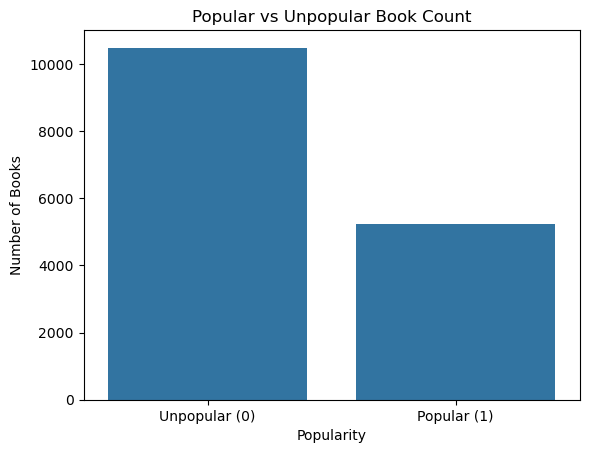

In [14]:
sns.countplot(data=books, x='popularity')
plt.xticks([0, 1], ['Unpopular (0)', 'Popular (1)'])
plt.title('Popular vs Unpopular Book Count')
plt.ylabel('Number of Books')
plt.xlabel('Popularity')
plt.show()

In [16]:
# Split all authors into a flat list
all_authors = books['authors'].dropna().apply(lambda x: [a.strip() for a in x.split(',')])
flat_authors = [author for sublist in all_authors for author in sublist]

# Count occurrences
author_counts = Counter(flat_authors)

# Convert to DataFrame
author_df = pd.DataFrame(author_counts.items(), columns=['Author', 'Book Count'])
author_df = author_df.sort_values(by='Book Count', ascending=False)

print(author_df.head(15)) 


                     Author  Book Count
109      'Charlotte Brontë'         126
51        'Charles Dickens'         109
131   'Christopher Paolini'          90
157         'Thomas Harris'          85
306           'Marc Cactus'          70
1700         'Gary Chapman'          49
75            'Julia Quinn'          47
1027      'Nicholas Sparks'          45
853           'Oscar Wilde'          45
102          'Nora Roberts'          45
91          'Donald Miller'          45
412     'Catherine Coulter'          43
60            'Kate Chopin'          42
553          'Thomas Hardy'          38
440        'Ashley Audrain'          38


In [23]:
# Flatten the list of all categories
all_categories = books['categories'].dropna().apply(lambda x: [cat.strip() for cat in x.split(',')])
flat_categories = [cat for sublist in all_categories for cat in sublist]

# Count the number of books in each category
category_counts = Counter(flat_categories)

# Convert to DataFrame
category_df = pd.DataFrame(category_counts.items(), columns=['Category', 'Book Count'])
category_df = category_df.sort_values(by='Book Count', ascending=False)

print(category_df.head(15))

                       Category  Book Count
10                    'Fiction'        3520
1                    'Religion'        1053
7   'Biography & Autobiography'         852
11           'Juvenile Fiction'         815
0                     'History'         754
9        'Business & Economics'         707
17                  'Computers'         513
21     'Family & Relationships'         486
18           'Health & Fitness'         414
26                    'Cooking'         398
3                Mind & Spirit'         360
2                         'Body         360
6                       'Music'         306
40        'Juvenile Nonfiction'         280
20                  'Self-Help'         263


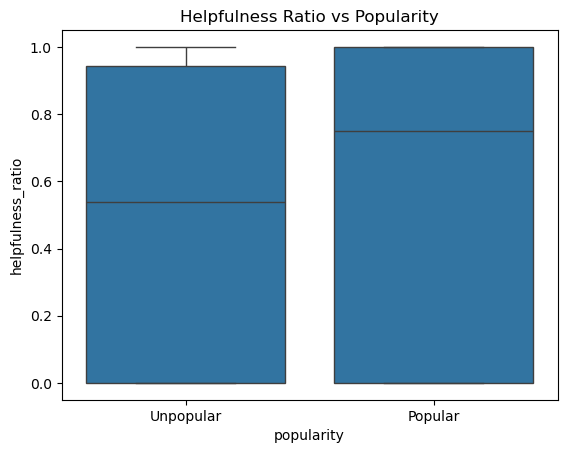

In [24]:
# Split into helpful and total votes
books[['helpful_votes', 'total_votes']] = books['review/helpfulness'].fillna("0/0").str.split('/', expand=True).astype(int)

# Create a helpfulness ratio (avoid division by zero)
books['helpfulness_ratio'] = books.apply(
    lambda row: row['helpful_votes'] / row['total_votes'] if row['total_votes'] > 0 else 0,
    axis=1
)

sns.boxplot(x='popularity', y='helpfulness_ratio', data=books)
plt.title("Helpfulness Ratio vs Popularity")
plt.show()

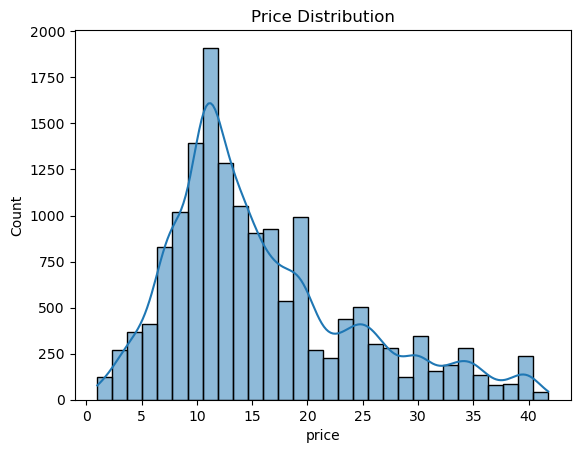

In [28]:
sns.histplot(books['price'], bins=30, kde=True)
plt.title('Price Distribution')
plt.show()

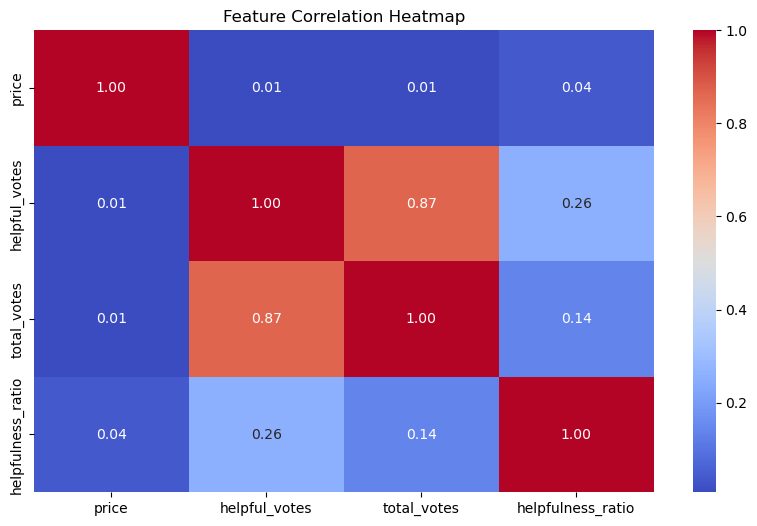

In [30]:
numeric_cols = books.select_dtypes(include=['float64', 'int64'])

# Compute correlation matrix
corr_matrix = numeric_cols.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

# Binary Encoding

In [34]:
books['popularity'] = books['popularity'].map({'Popular': 1, 'Unpopular': 0})

In [36]:
# Word counts from review/summary and review/text, handling NaN and non-string values
books['summary_word_count'] = books['review/summary'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
books['text_word_count'] = books['review/text'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

# Number of authors
books['num_authors'] = books['authors'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)

# Number of categories
books['num_categories'] = books['categories'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)

# Build author list and count dictionary
author_list = books['authors'].apply(lambda x: [a.strip() for a in x.split(',')] if isinstance(x, str) else [])
flat_authors = [author for sublist in author_list for author in sublist]
author_count = Counter(flat_authors)

# Average number of books per author
def author_avg_books(authors):
    if not isinstance(authors, str):
        return 0
    authors = [a.strip() for a in authors.split(',')]
    if len(authors) == 0:
        return 0
    return sum([author_count.get(a, 0) for a in authors]) / len(authors)

books['author_avg_book_count'] = books['authors'].apply(author_avg_books)

In [38]:
# Final feature list
features = [
    'price', 'helpfulness_ratio', 'summary_word_count', 'text_word_count',
    'helpful_votes', 'total_votes', 'num_authors', 'num_categories', 'author_avg_book_count'
]

X = books[features]
y = books['popularity']

In [40]:
books.head()

,title,price,review/helpfulness,review/summary,review/text,description,authors,categories,popularity,helpful_votes,total_votes,helpfulness_ratio,summary_word_count,text_word_count,num_authors,num_categories,author_avg_book_count
0,We Band of Angels: The Untold Story of America...,10.88,2/3,A Great Book about women in WWII,I have alway been a fan of fiction books set i...,"In the fall of 1941, the Philippines was a gar...",'Elizabeth Norman','History',0,2,3,0.666667,7,90,1,1,8.0
1,Prayer That Brings Revival: Interceding for Go...,9.35,0/0,Very helpful book for church prayer groups and...,Very helpful book to give you a better prayer ...,"In Prayer That Brings Revival, best-selling au...",'Yong-gi Cho','Religion',0,0,0,0.000000,13,23,1,1,2.0
2,The Mystical Journey from Jesus to Christ,24.95,17/19,Universal Spiritual Awakening Guide With Some ...,The message of this book is to find yourself a...,THE MYSTICAL JOURNEY FROM JESUS TO CHRIST Disc...,'Muata Ashby',"'Body, Mind & Spirit'",0,17,19,0.894737,9,1174,1,2,3.0
3,Death Row,7.99,0/1,Ben Kincaid tries to stop an execution.,The hero of William Bernhardt's Ben Kincaid no...,"Upon receiving his execution date, one of the ...",'Lynden Harris','Social Science',0,0,1,0.000000,7,370,1,1,1.0
4,Sound and Form in Modern Poetry: Second Editio...,32.50,18/20,good introduction to modern prosody,There's a lot in this book which the reader wi...,An updated and expanded version of a classic a...,"'Harvey Seymour Gross', 'Robert McDowell'",'Poetry',0,18,20,0.900000,5,341,2,1,2.0


In [42]:
X.head()

,price,helpfulness_ratio,summary_word_count,text_word_count,helpful_votes,total_votes,num_authors,num_categories,author_avg_book_count
0,10.88,0.666667,7,90,2,3,1,1,8.0
1,9.35,0.000000,13,23,0,0,1,1,2.0
2,24.95,0.894737,9,1174,17,19,1,2,3.0
3,7.99,0.000000,7,370,0,1,1,1,1.0
4,32.50,0.900000,5,341,18,20,2,1,2.0


In [44]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: popularity, dtype: int64

# Logistic Regression

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [49]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_scaled, y_train)

y_pred = logreg.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.6723918575063613
              precision    recall  f1-score   support

           0       0.67      0.99      0.80      2112
           1       0.53      0.02      0.03      1032

    accuracy                           0.67      3144
   macro avg       0.60      0.50      0.42      3144
weighted avg       0.63      0.67      0.55      3144



# Random Forest Classifier

In [52]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)

model_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", model_accuracy)
print(classification_report(y_test, y_pred))


Accuracy: 0.7153307888040712
              precision    recall  f1-score   support

           0       0.74      0.88      0.81      2112
           1       0.60      0.39      0.47      1032

    accuracy                           0.72      3144
   macro avg       0.67      0.63      0.64      3144
weighted avg       0.70      0.72      0.70      3144



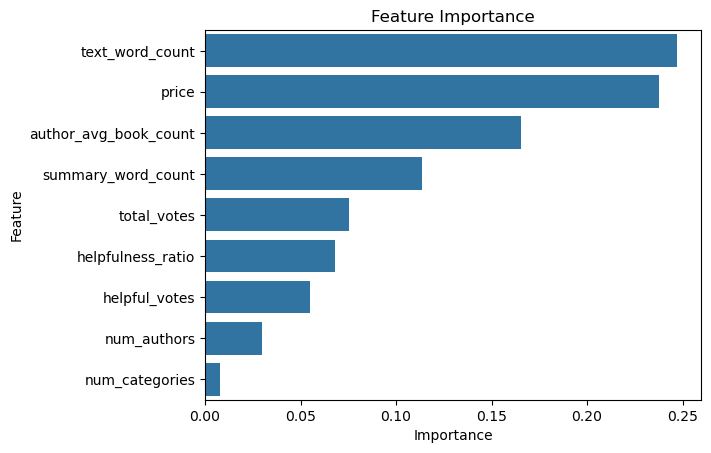

In [53]:
importances = model.feature_importances_
feature_names = X.columns
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=feat_df)
plt.title('Feature Importance')
plt.show()


# XGBoost

In [55]:
# Features
numeric_features = [
    'price', 'helpful_votes', 'total_votes', 'helpfulness_ratio',
    'summary_word_count', 'text_word_count', 'num_authors',
    'num_categories', 'author_avg_book_count'
]

text_features = ['review/summary', 'review/text', 'description']

books['review/summary'] = books['review/summary'].fillna('')
books['review/text'] = books['review/text'].fillna('')
books['description'] = books['description'].fillna('')


# Preprocessing
numeric_transformer = StandardScaler()
text_transformer = TfidfVectorizer(max_features=500)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('text_summary', text_transformer, 'review/summary'),
        ('text_review', text_transformer, 'review/text'),
        ('text_desc', text_transformer, 'description'),
    ]
)

# Build the pipeline
clf = make_pipeline(
    preprocessor,
    xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
)

# Prepare data
X = books[numeric_features + text_features]
y = books['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
print("XGBoost Results:")
print(classification_report(y_test, y_pred))


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:34:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Results:
              precision    recall  f1-score   support

           0       0.81      0.91      0.86      2112
           1       0.75      0.57      0.64      1032

    accuracy                           0.79      3144
   macro avg       0.78      0.74      0.75      3144
weighted avg       0.79      0.79      0.79      3144



In [56]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 79.48%
